## Change Detector in 4D tomography  

The goal of this notebook is to test the "change detector" for the full 4D stream (25 rotations). The change detector returns coordinates of ROI(s) inside a 3D volume where morphology changes w.r.t the previous 3D image. To measure this change, a sub-volume (or patch) at time-step = t and the same patch from time-step = t-1 is passed through a latent feature extractor, then the Euclidean distance between the latent embeddings is computed as the "change metric". The *Patches* data structure stores these coordinates and the window size used to measure the change. An array of this metric computed for different patches is then sorted to find the top 'n' patches that changed. Then this is visualized in a point cloud.  

**Data:** Coal-ice experiment data from Viktor Nikitin (APS 2-BM).  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from ct_segnet import viewer
# from features3D import FeatureExtractor4D
from tomo_encoders.patches import Patches
import tensorflow as tf
from tomo_encoders.neural_nets.porosity_encoders import build_CAE_3D
sys.path.append('../.')
from recon4D import DataGetter
import time
from feature_detection import SelfSupervisedCAE
from vis_utils import *

In [2]:
# Reconstruction stuff
fnames = ['/data02/MyArchive/coalice/melting_086.h5', \
          '/data02/MyArchive/coalice/flat_fields_melting_086.h5', \
          '/data02/MyArchive/coalice/dark_fields_melting_086.h5']
ntheta = 361 # these many projections per 180 degree spin
recon_params = {"mask_ratio" : None, \
                "contrast_s" : 0.01}

Shape of projection image: (1, 600, 960)
center = 471.00


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

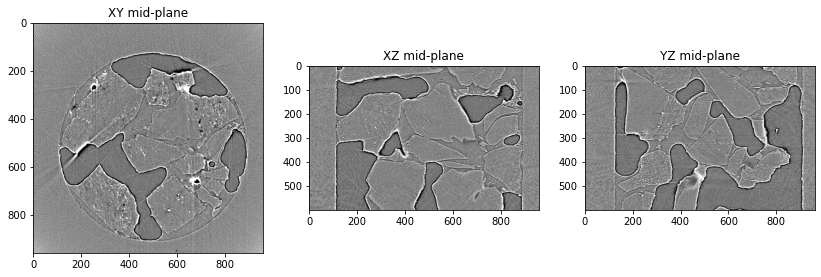

In [3]:
dget = DataGetter(*fnames, ntheta)
vol_tzero = dget.reconstruct_window(0,dget.find_center(0), **recon_params)
fig, ax = plt.subplots(1,3, figsize = (14,6))
viewer.view_midplanes(vol = vol_tzero, ax = ax)   

## Test it  

In [4]:
bin_tag = 'bin1'
bin_size = (64,64,64)
model_names = {"CAE" : "CAE_111d128_coal-ice-tzero-%s"%bin_tag, \
               "latent_embedder" : "latent_embedder_111d128_coal-ice-tzero-%s"%bin_tag}
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/coalice'

fe = SelfSupervisedCAE(vol_tzero.shape, \
                         model_initialization = 'load-model', \
                         model_names = model_names, model_path = model_path)

center = 471.00
total time for change detector = 22.05 seconds
Done h_delta_t3600
center = 471.00
total time for change detector = 22.32 seconds
Done h_delta_t7200
center = 471.00
total time for change detector = 22.29 seconds
Done h_delta_t8640
center = 471.00
total time for change detector = 22.30 seconds
Done h_delta_t10800
center = 471.00
total time for change detector = 22.24 seconds
Done h_delta_t14400
center = 471.00
total time for change detector = 22.38 seconds
Done h_delta_t18000


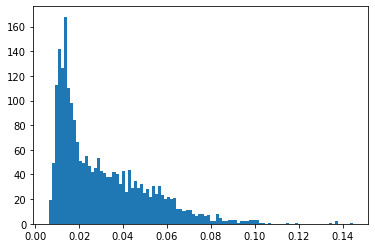

In [10]:
p_grid = Patches(vol_tzero.shape, initialize_by = "grid", patch_size = bin_size)
p_hist = p_grid.copy()
idx_list = [720*5, 720*10, 720*12, 720*15, 720*20, 720*25]
for idx in idx_list:
    vol_t = dget.reconstruct_window(idx,dget.find_center(idx), **recon_params)
    p_t = fe.detect_changes(vol_tzero, vol_t, p_grid.copy())
    p_hist.add_features(p_t.features_to_numpy(["h_delta"]), names = ["h_delta_t%02d"%idx])
    print("Done h_delta_t%02d"%idx)
    
h = plt.hist(p_hist.features[:,0], bins = 100)

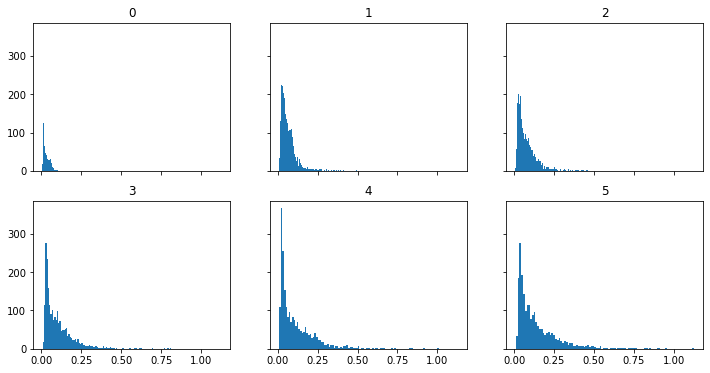

In [11]:
fig, ax = plt.subplots(2,3, figsize = (12,6), sharex = True, sharey = True)
for ii in range(6):
    ax.flat[ii].hist(p_hist.features[:,ii], bins = 100)
    ax.flat[ii].set_title("%i"%ii)

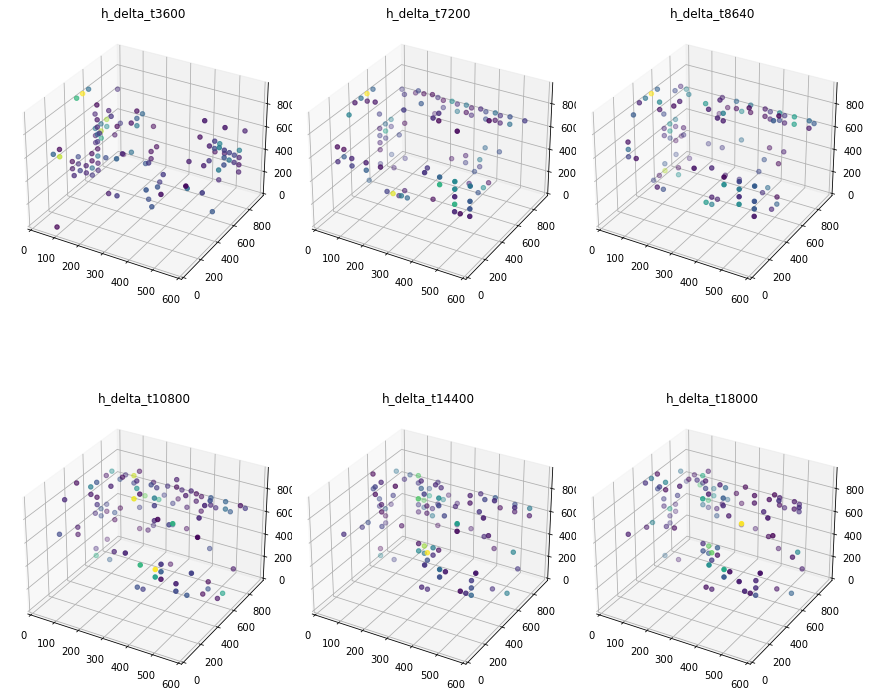

In [12]:
fig = plt.figure(figsize = (12,12))
max_pts = 100
for ii in range(6):
    p_tmp = p_hist.select_by_feature(max_pts, ife = ii, selection_by = "highest")
    ax = fig.add_subplot(2,3,ii+1, projection = '3d')
    p_tmp.plot_3D_feature(ii,ax)    
    ax.set_title("%s"%p_hist.feature_names[ii])
fig.tight_layout()

In [13]:
p_hist.features.shape

(2250, 6)

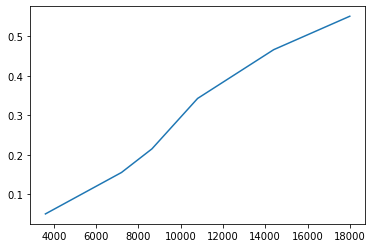

In [14]:
p_tmp = p_hist.select_by_feature(100, ife = 5)
fig, ax = plt.subplots(1,1)
ax.plot(np.asarray(idx_list), np.mean(p_tmp.features, axis = 0))